<div align="center">

#   Introdução à óptica não-linear

**Autor.** Carlos Antunis Bonfim da Silva Santos

</div>

Fenômenos ópticos são parte fundamental do cotidiano humano, contudo, certos aspectos destes fenômenos são regularmente suprimidos na natureza devido à baixa intensidade dos campos eletromagnéticos utilizados. Com a descoberta do Laser, se percebeu que a altas intensidades os materiais exibem respostas não-lineares à presença de luz. Neste notebook iremos abordar as origens desses fenômenos utilizando uma descrição dos efeitos que campos intensos imprimem sobre as cargas elétricas presentes nos materiais. 

In [1]:
using GLMakie;
using FFTW;
const mech = include("src/mechanics.jl");

<div align="center">

##  Oscilações

</div>

Iremos modelar aqui os materiais como uma coleção de cargas elétricas, o elétron de valência e o caroço iônico (núcleo e demais elétrons), sendo o elétron mais importante destes à dinâmica dado que possui mais mobilidade que o caroço iônico, que iremos tomar que não se move. Em materiais dielétricos, diferentemente de materiais condutores, os elétrons estão ligados ao caroço iônico apresentando apenas certa elasticidade, assim ao ser impelido pela luz (um campo eletromagnético) estes se deslocam de sua posição gerando um dipolo elétrico induzido. Por simplicidade, em nosso modelo, adotemos que a dinâmica do elétrons se da de modo que pode ser descrita como

$$
    \ddot{x} + 2\zeta\dot{x} + \omega_0^2x - (\xi x^2 + \eta x^3 + ...) = -\frac{e}{m}E(t)\text{.}
$$

In [2]:
Δx, v_0 = 0., 2√2π;

ω_0 = 2π;

ζ_sub = .5ω_0;  # underdamped
ζ_crt = ω_0;    # critically damped
ζ_sup = 2.0ω_0; # overdamped

E_0 = 50.;
ω_1 = .5ω_0;    # driving frequency of field 1
ω_2 = .5ω_0;    # driving frequency of field 2

drivingField = t -> E_0 * (cos(ω_1 * t) + cos(ω_2 * t));

ξ = 1.25ω_0;    # anharmonicity parameter

nonlinearOscillation = u -> ξ * u^2;

dt = 0.01;

ts = dt:dt:5;
ωs = fftshift(fftfreq(length(ts), 1/dt));

<div align="center">

###  Osciladores harmônicos

</div>

No regime harmônico de oscilações, não há campo externo aplicado, e a oscilação ocorre apenas nas vizinhanças do equilíbrio estável do poço de potencial gerado pela estrutura do material, ou seja, a dinâmica é regida pela seguinte equação

$$
    \ddot{x} + \omega_0^2x = 0\text{,}
$$

Podemos notar que as funções senoidais ($cos(\omega_0t)$ e $sin(\omega_0t)$) servem como uma base ortogonal do kernel de tal operador, e que por conseguinte esta base expande tal subespaço de funções, ou seja, qualquer solução da equação diferencial seguirá

$$
    x(t) = Acos(\omega_0t) + Bsin(\omega_0t)\text{.}
$$

Notando que $x(t) = \sqrt{A^2 + B^2}((A / \sqrt{A^2 + B^2})cos(\omega_0t) + (B / \sqrt{A^2 + B^2})sin(\omega_0t))$, ao tomar $x_0 = \sqrt{A^2 + B^2}$, $cos(\phi) = A / \sqrt{A^2 + B^2}$ e $sin(\phi) = - B / \sqrt{A^2 + B^2}$ (ou seja $\phi = arctg(B/A)$, obtemos
$$
    x(t) = x_0cos(\omega_0t + \phi)\text{,}
$$

apresentando assim por comportamento mecânico, um movimento oscilatório simples.

In [3]:
Φ = mech.harmonicOscillator(Δx, v_0, ω_0);

fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "x", ylabel = "y", limits = ((-5, +5), (-2.5, +2.5)));

Points = [(Φ.x, 0)];
xs = [Φ.x];

trajectory = lines!(ax, Points, color = :gray, linestyle = :dash);
point = scatter!(ax, [(Φ.x, 0)], markersize = 15, color = :black);

display(fig);
record(fig, "assets/lecture-1/harmonic-oscillator.gif", ts; framerate=15) do t
    global Φ, Points;
    mech.evolve(Φ, dt);

    push!(Points, (Φ.x, 0))
    push!(xs, Φ.x)

    if length(Points) > 15
        popfirst!(Points);
    end

    trajectory[1][] = Points;
    point[1][] = [(Φ.x, 0)];

    display(fig);
end;

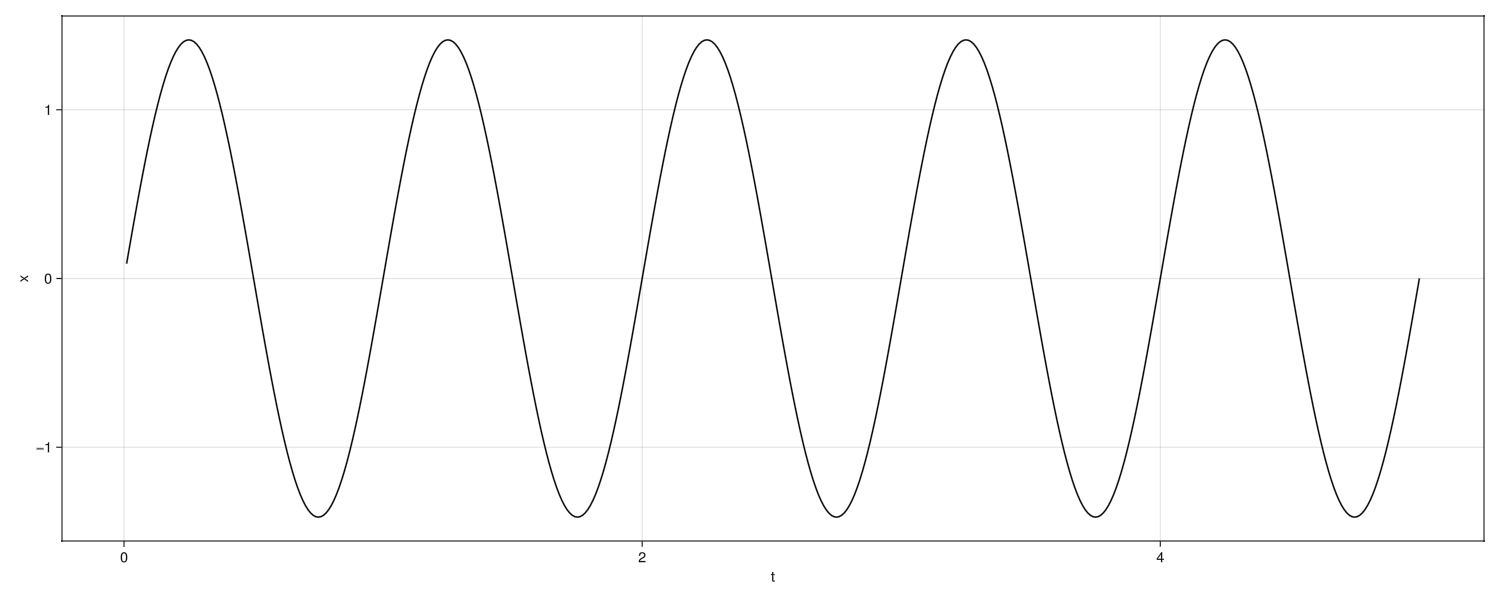

In [4]:
fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "t", ylabel = "x");

line = lines!(ax, ts, xs[2:end], color = :black);

save("assets/lecture-1/harmonic-oscillator.png", fig);
display("image/png", read("assets/lecture-1/harmonic-oscillator.png"));

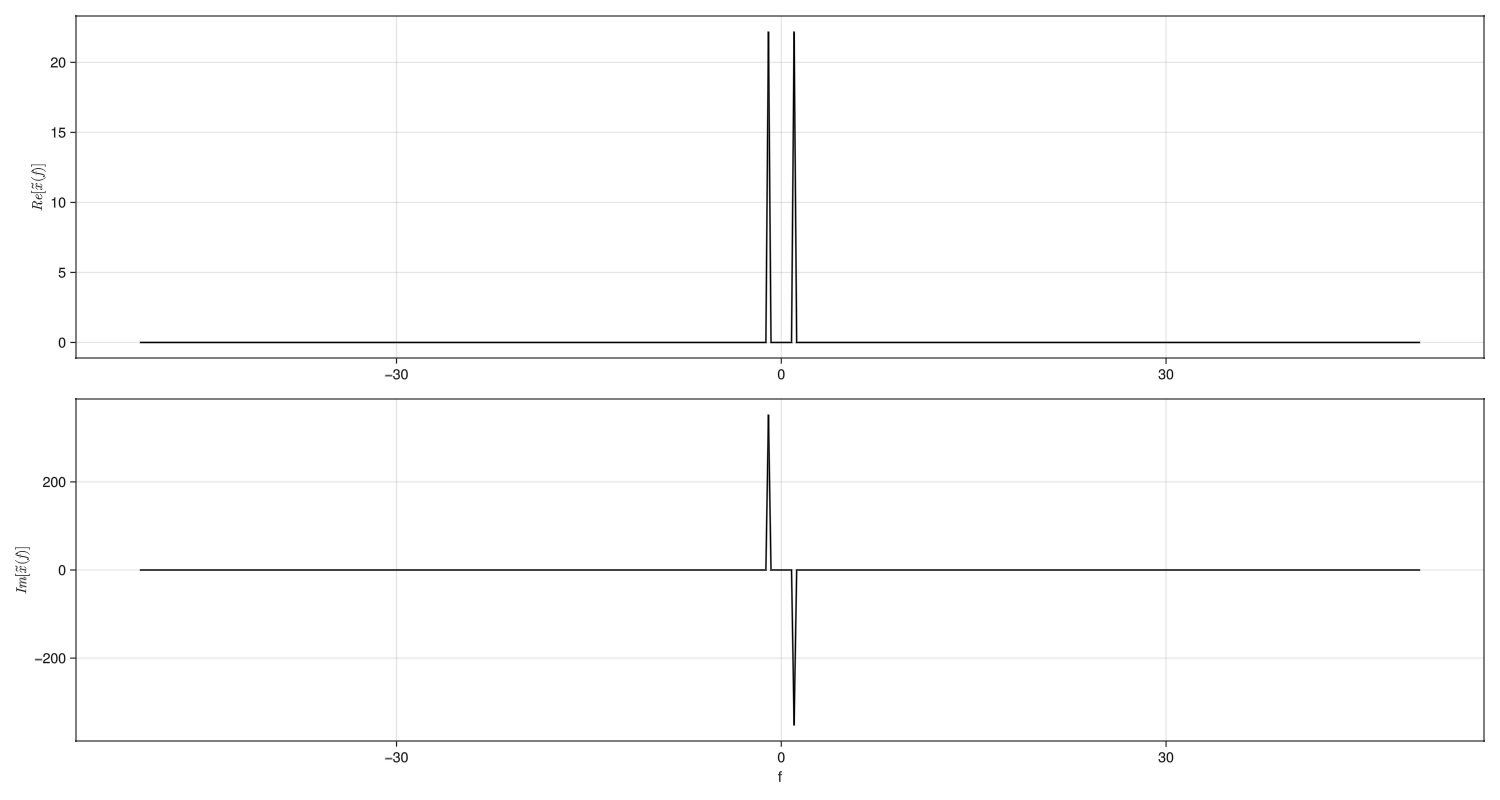

In [5]:
fig = Figure(size = (1500, 800));
ax = [
    Axis(fig[1, 1], ylabel = L"Re[\tilde{x}(f)]"),
    Axis(fig[2, 1], ylabel = L"Im[\tilde{x}(f)]", xlabel = "f")
];

f = fftshift(fft(xs[2:end]));

line = lines!(ax[1], ωs, real(f), color = :black);
line = lines!(ax[2], ωs, imag(f), color = :black);

save("assets/lecture-1/harmonic-oscillator-ft.png", fig);
display("image/png", read("assets/lecture-1/harmonic-oscillator-ft.png"));

<div align="center">

###  Osciladores amortecidos

</div>

<div align="center">

####  Regime subamortecido

</div>

In [6]:
Φ = mech.dampedHarmonicOscillator(Δx, v_0, ω_0, ζ_sub);

fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "x", ylabel = "y", limits = ((-5, +5), (-2.5, +2.5)));

Points = [(Φ.x, 0)];
xs = [Φ.x];

trajectory = lines!(ax, Points, color = :gray, linestyle = :dash);
point = scatter!(ax, [(Φ.x, 0)], markersize = 15, color = :black);

display(fig);
record(fig, "assets/lecture-1/underdamped-harmonic-oscillator.gif", ts; framerate=15) do t
    global Φ, Points;
    mech.evolve(Φ, dt);

    push!(Points, (Φ.x, 0))
    push!(xs, Φ.x)

    if length(Points) > 15
        popfirst!(Points);
    end

    trajectory[1][] = Points;
    point[1][] = [(Φ.x, 0)];

    display(fig);
end;

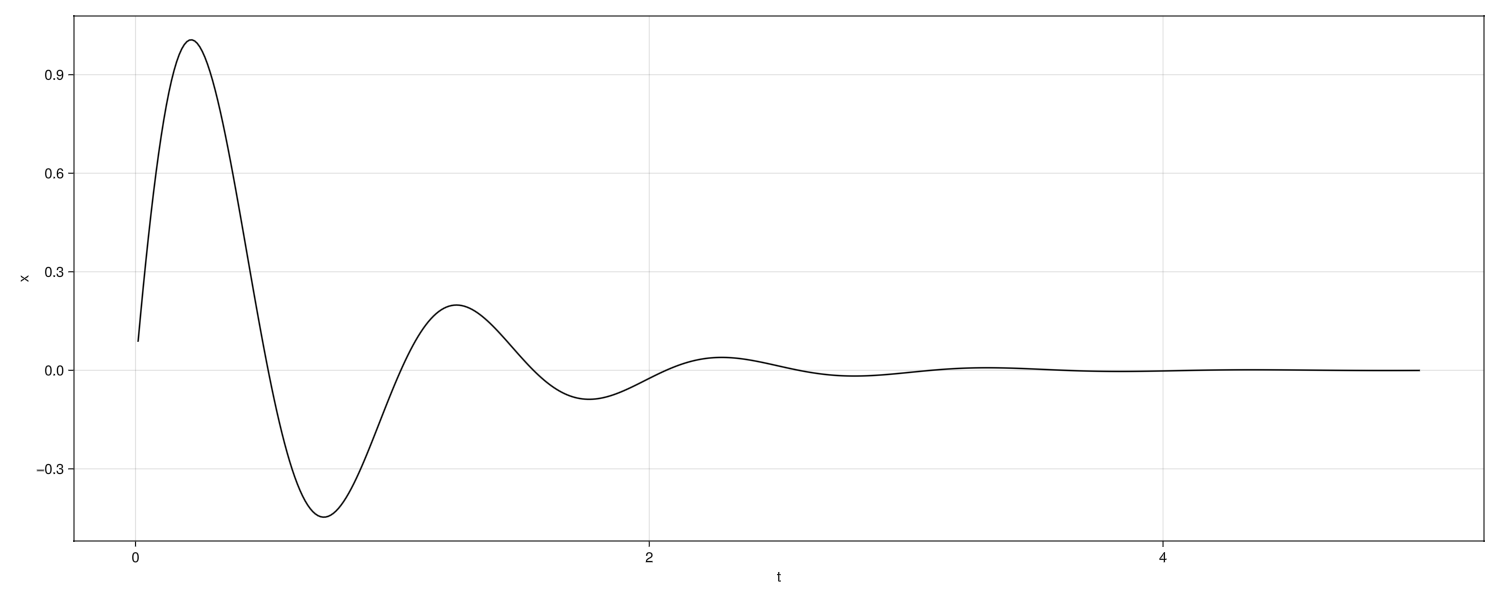

In [7]:
fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "t", ylabel = "x");

line = lines!(ax, ts, xs[2:end], color = :black);

save("assets/lecture-1/underdamped-harmonic-oscillator.png", fig);
display("image/png", read("assets/lecture-1/underdamped-harmonic-oscillator.png"));

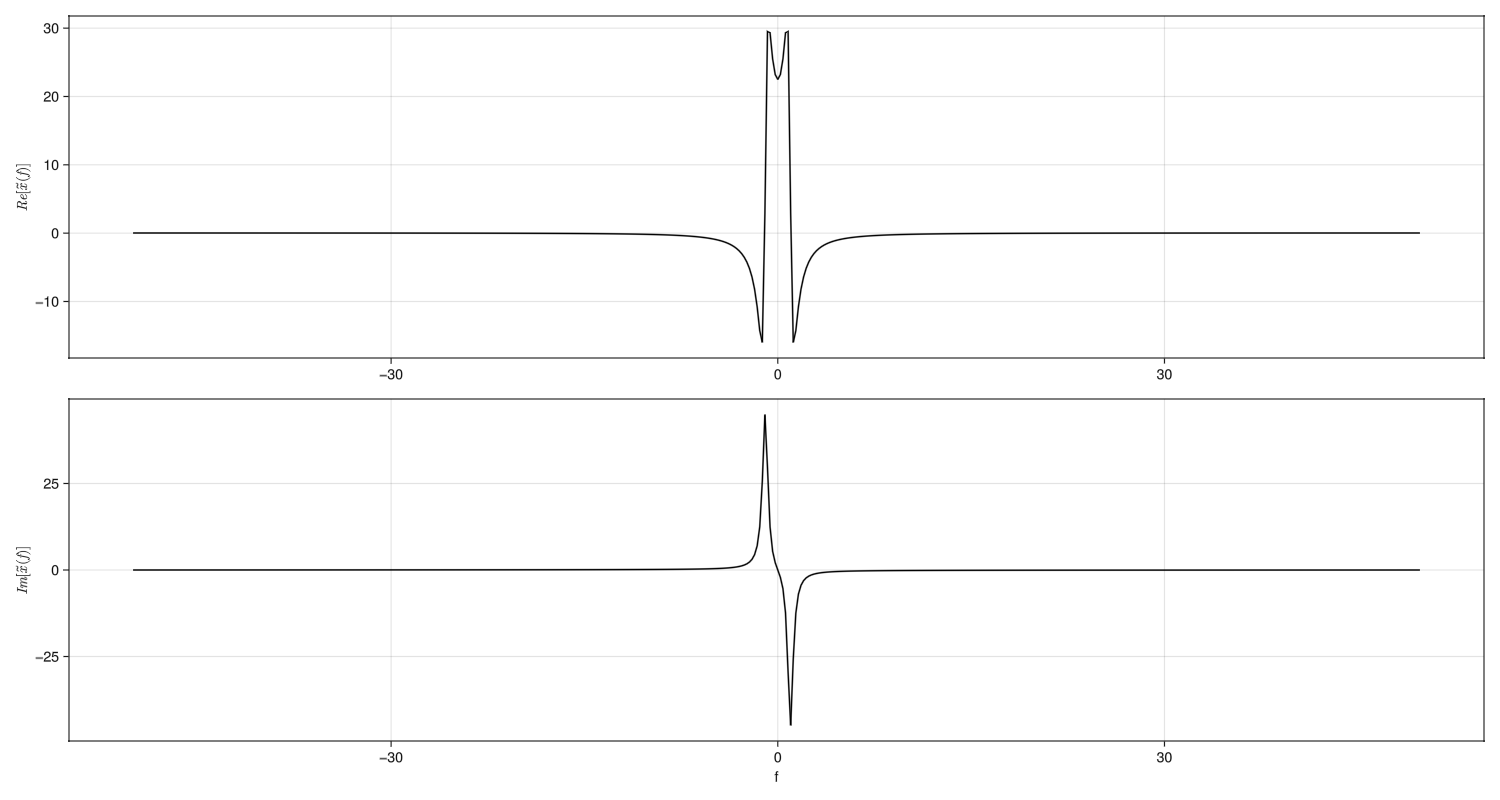

In [8]:
fig = Figure(size = (1500, 800));
ax = [
    Axis(fig[1, 1], ylabel = L"Re[\tilde{x}(f)]"),
    Axis(fig[2, 1], ylabel = L"Im[\tilde{x}(f)]", xlabel = "f")
];

f = fftshift(fft(xs[2:end]));

line = lines!(ax[1], ωs, real(f), color = :black);
line = lines!(ax[2], ωs, imag(f), color = :black);

save("assets/lecture-1/underdamped-harmonic-oscillator-ft.png", fig);
display("image/png", read("assets/lecture-1/underdamped-harmonic-oscillator-ft.png"));

<div align="center">

####  Regime criticamente amortecido

</div>

In [9]:
Φ = mech.dampedHarmonicOscillator(Δx, v_0, ω_0, ζ_crt);

fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "x", ylabel = "y", limits = ((-5, +5), (-2.5, +2.5)));

Points = [(Φ.x, 0)];
xs = [Φ.x];

trajectory = lines!(ax, Points, color = :gray, linestyle = :dash);
point = scatter!(ax, [(Φ.x, 0)], markersize = 15, color = :black);

display(fig);
record(fig, "assets/lecture-1/critically-damped-harmonic-oscillator.gif", ts; framerate=15) do t
    global Φ, Points;
    mech.evolve(Φ, dt);

    push!(Points, (Φ.x, 0))
    push!(xs, Φ.x)

    if length(Points) > 15
        popfirst!(Points);
    end

    trajectory[1][] = Points;
    point[1][] = [(Φ.x, 0)];

    display(fig);
end;

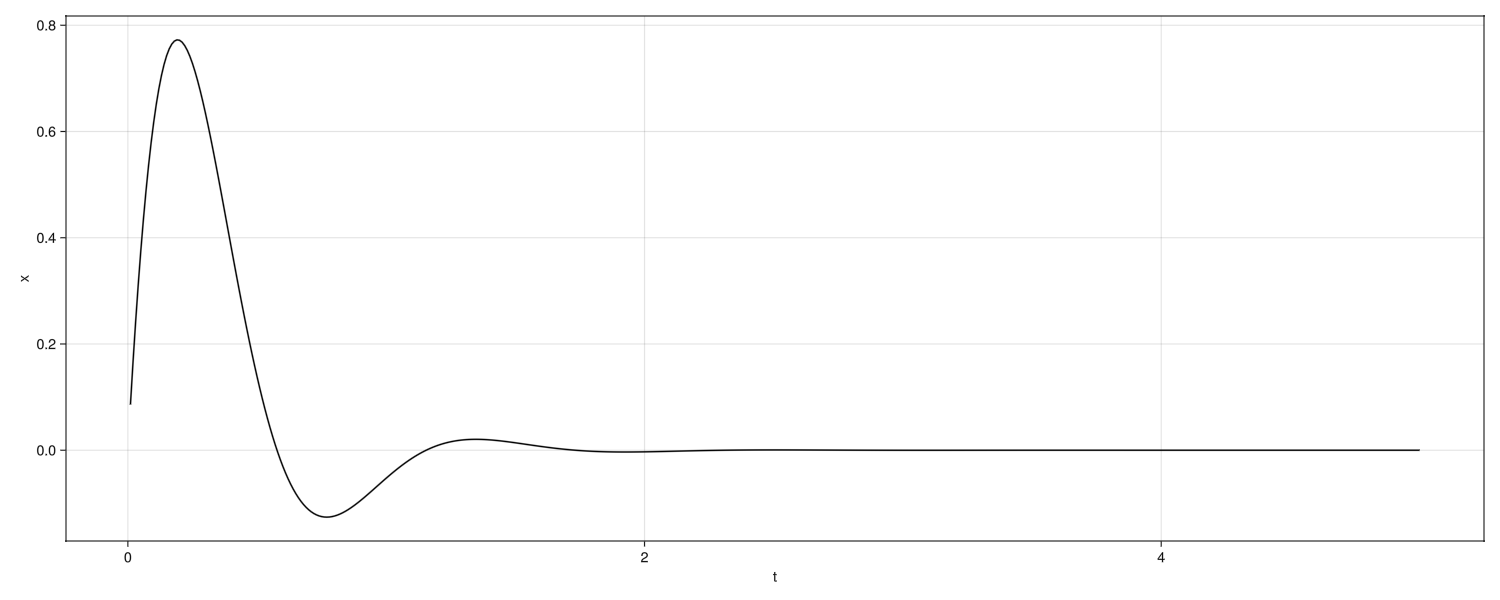

In [10]:
fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "t", ylabel = "x");

line = lines!(ax, ts, xs[2:end], color = :black);

save("assets/lecture-1/critically-damped-harmonic-oscillator.png", fig);
display("image/png", read("assets/lecture-1/critically-damped-harmonic-oscillator.png"));

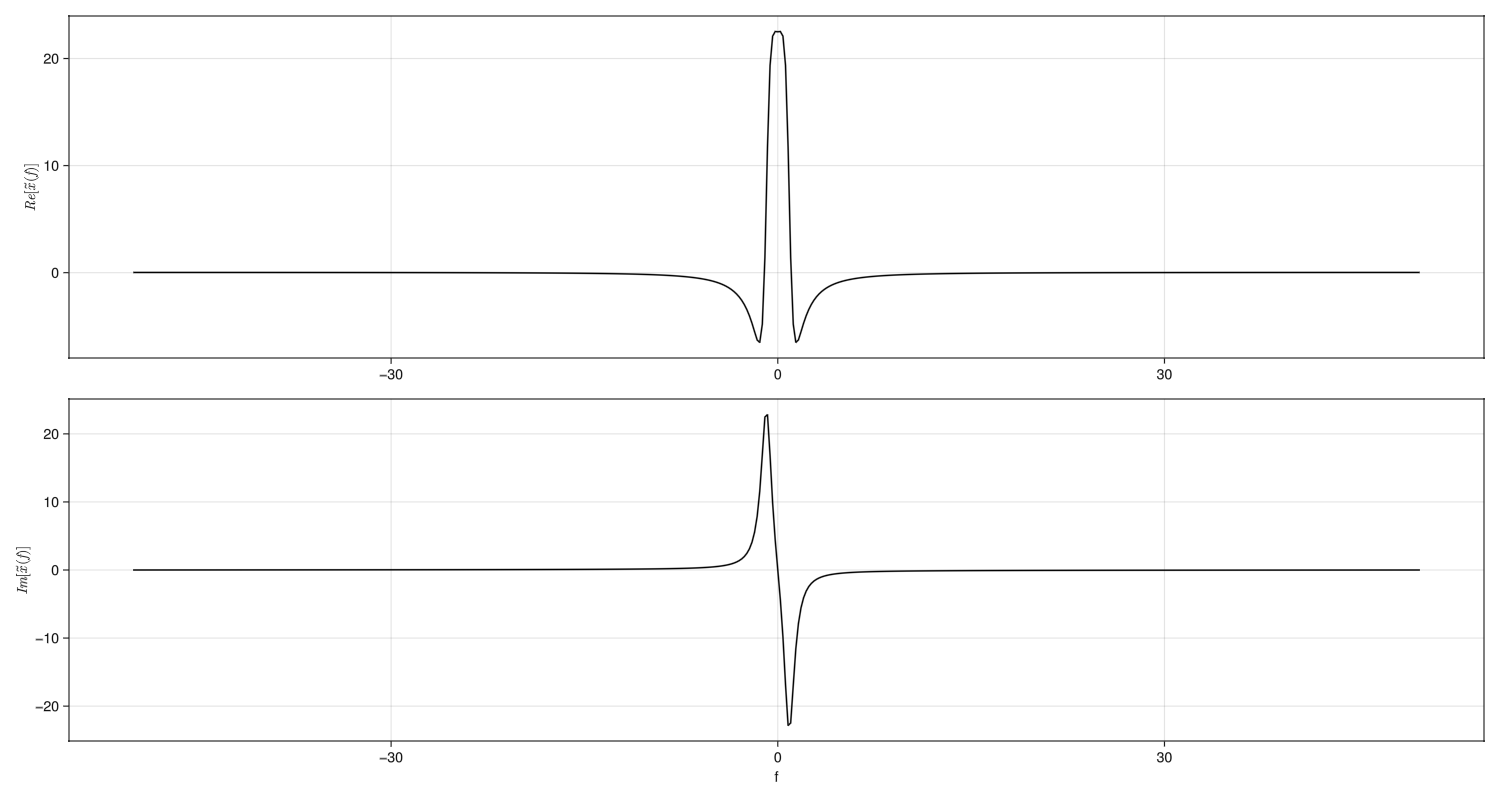

In [11]:
fig = Figure(size = (1500, 800));
ax = [
    Axis(fig[1, 1], ylabel = L"Re[\tilde{x}(f)]"),
    Axis(fig[2, 1], ylabel = L"Im[\tilde{x}(f)]", xlabel = "f")
];

f = fftshift(fft(xs[2:end]));

line = lines!(ax[1], ωs, real(f), color = :black);
line = lines!(ax[2], ωs, imag(f), color = :black);

save("assets/lecture-1/critically-damped-harmonic-oscillator-ft.png", fig);
display("image/png", read("assets/lecture-1/critically-damped-harmonic-oscillator-ft.png"));

<div align="center">

####  Regime superamortecido

</div>

In [12]:
Φ = mech.dampedHarmonicOscillator(Δx, v_0, ω_0, ζ_sup);

fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "x", ylabel = "y", limits = ((-5, +5), (-2.5, +2.5)));

Points = [(Φ.x, 0)];
xs = [Φ.x];

trajectory = lines!(ax, Points, color = :gray, linestyle = :dash);
point = scatter!(ax, [(Φ.x, 0)], markersize = 15, color = :black);

display(fig);
record(fig, "assets/lecture-1/overdamped-harmonic-oscillator.gif", ts; framerate=15) do t
    global Φ, Points;
    mech.evolve(Φ, dt);

    push!(Points, (Φ.x, 0));
    push!(xs, Φ.x);

    if length(Points) > 15
        popfirst!(Points);
    end

    trajectory[1][] = Points;
    point[1][] = [(Φ.x, 0)];

    display(fig);
end;

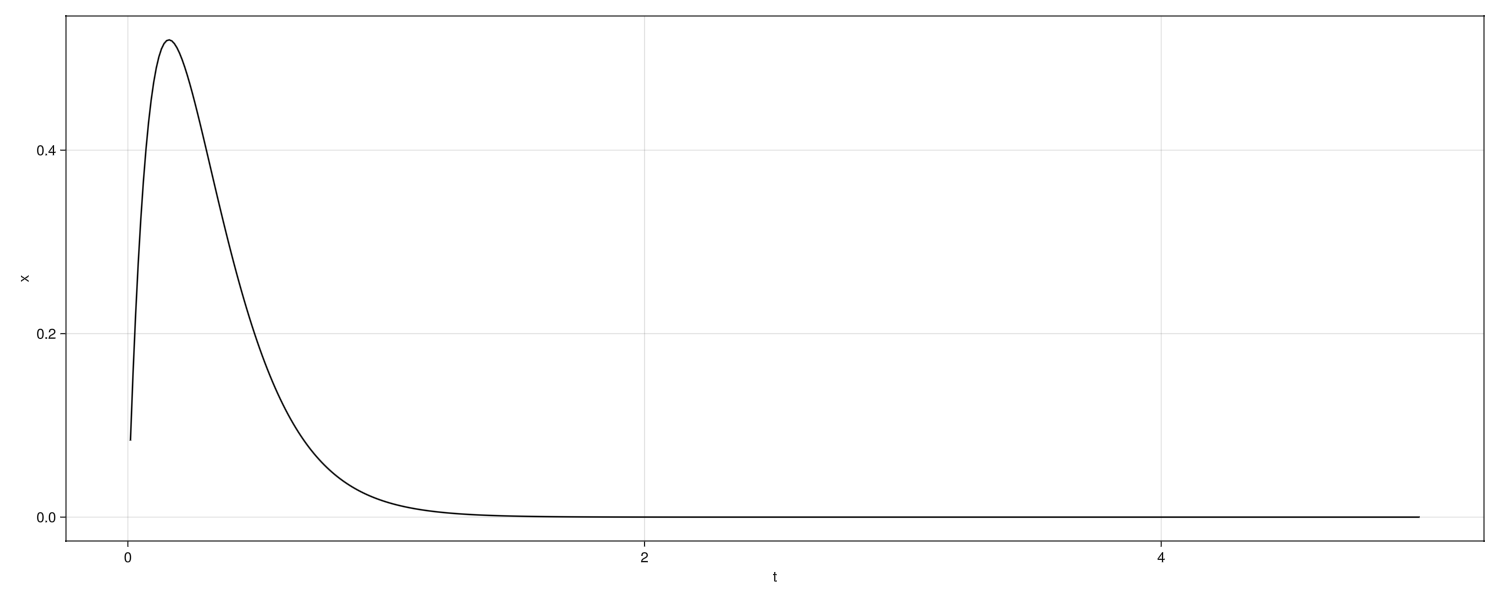

In [13]:
fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "t", ylabel = "x");

line = lines!(ax, ts, xs[2:end], color = :black);

save("assets/lecture-1/overdamped-harmonic-oscillator.png", fig);
display("image/png", read("assets/lecture-1/overdamped-harmonic-oscillator.png"));

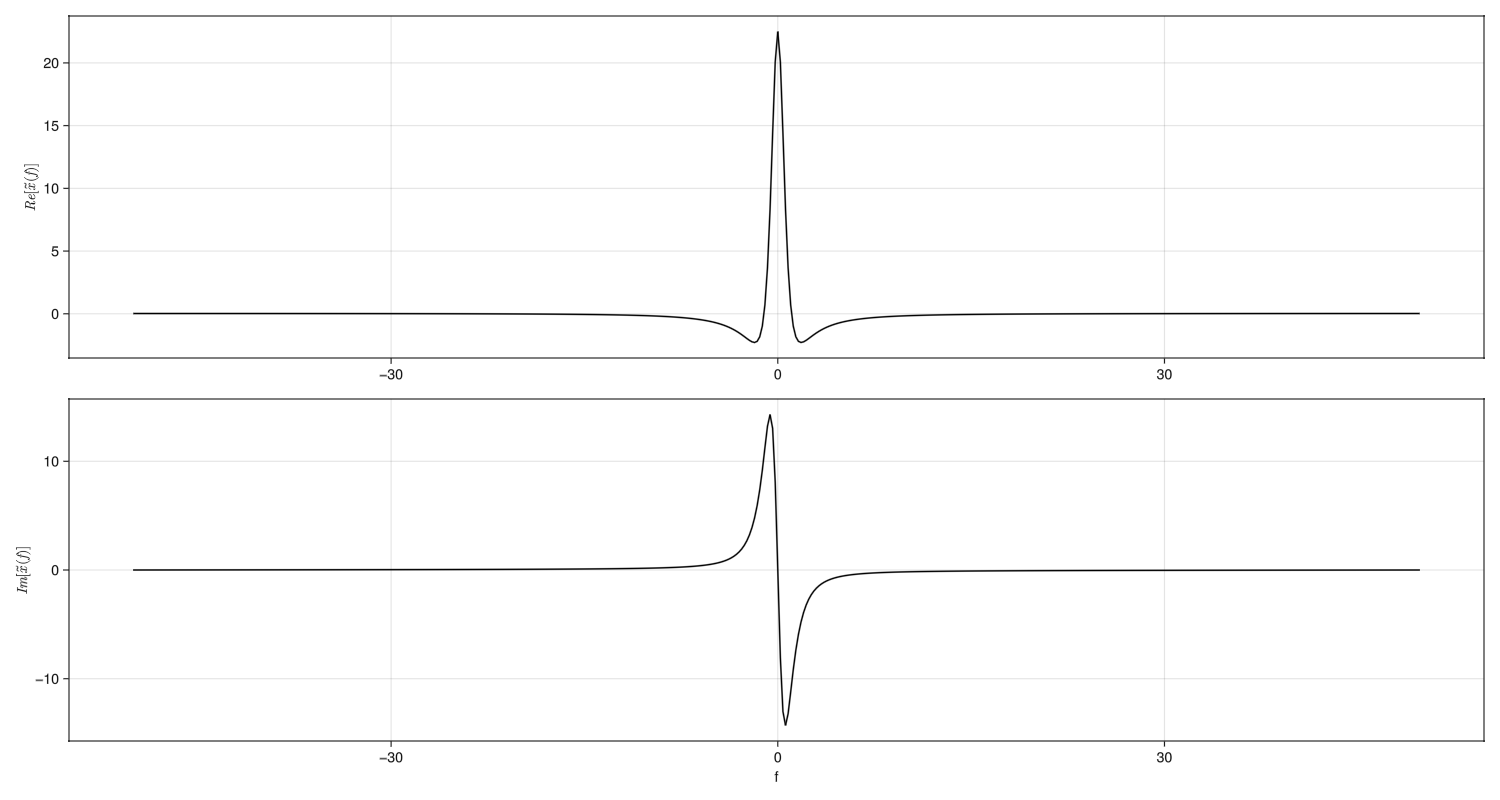

In [14]:
fig = Figure(size = (1500, 800));
ax = [
    Axis(fig[1, 1], ylabel = L"Re[\tilde{x}(f)]"),
    Axis(fig[2, 1], ylabel = L"Im[\tilde{x}(f)]", xlabel = "f")
];

f = fftshift(fft(xs[2:end]));

line = lines!(ax[1], ωs, real(f), color = :black);
line = lines!(ax[2], ωs, imag(f), color = :black);

save("assets/lecture-1/overdamped-harmonic-oscillator-ft.png", fig);
display("image/png", read("assets/lecture-1/overdamped-harmonic-oscillator-ft.png"));

<div align="center">

###  Osciladores forçados

</div>

In [15]:
Φ = mech.drivenHarmonicOscillator(Δx, v_0, ω_0, ζ_sup, drivingField);

fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "x", ylabel = "y", limits = ((-5, +5), (-2.5, +2.5)));

Points = [(Φ.x, 0)];
xs = [Φ.x];

trajectory = lines!(ax, Points, color = :gray, linestyle = :dash);
point = scatter!(ax, [(Φ.x, 0)], markersize = 15, color = :black);

display(fig);
record(fig, "assets/lecture-1/driven-harmonic-oscillator.gif", ts; framerate=15) do t
    global Φ, Points;
    mech.evolve(Φ, dt);

    push!(Points, (Φ.x, 0));
    push!(xs, Φ.x);

    if length(Points) > 15
        popfirst!(Points);
    end

    trajectory[1][] = Points;
    point[1][] = [(Φ.x, 0)];

    display(fig);
end;

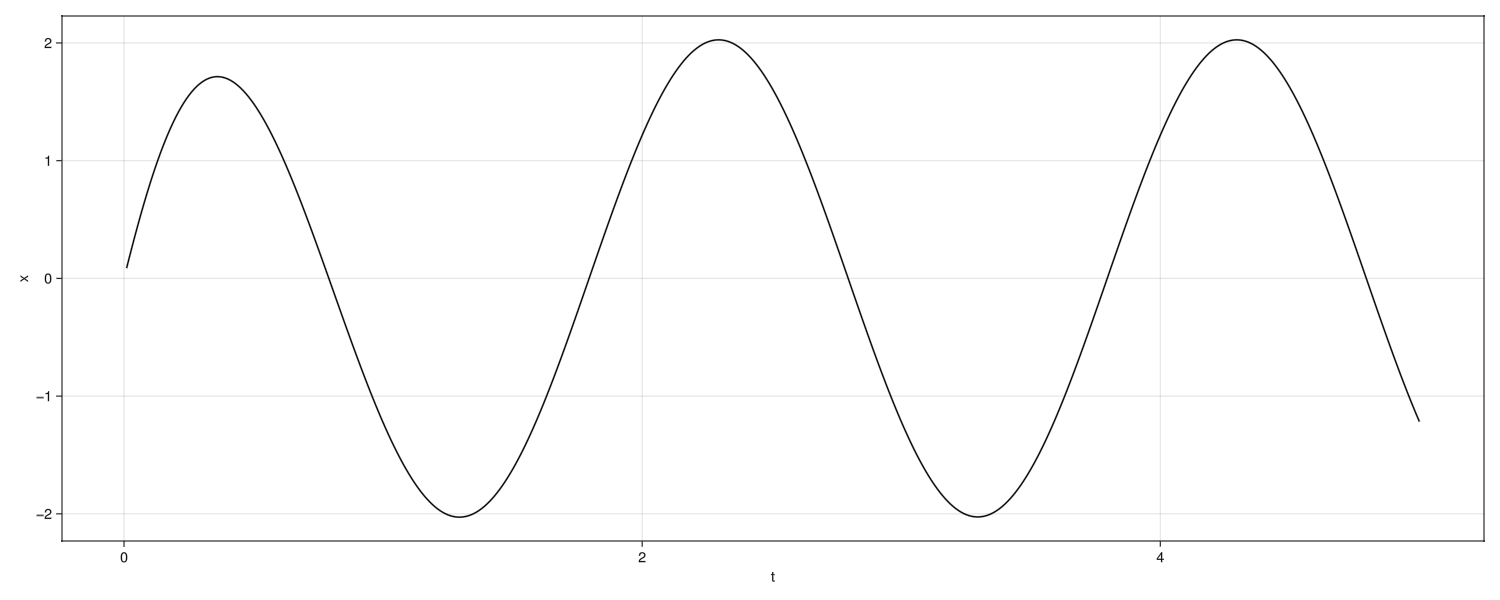

In [16]:
fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "t", ylabel = "x");

line = lines!(ax, ts, xs[2:end], color = :black);

save("assets/lecture-1/driven-harmonic-oscillator.png", fig);
display("image/png", read("assets/lecture-1/driven-harmonic-oscillator.png"));

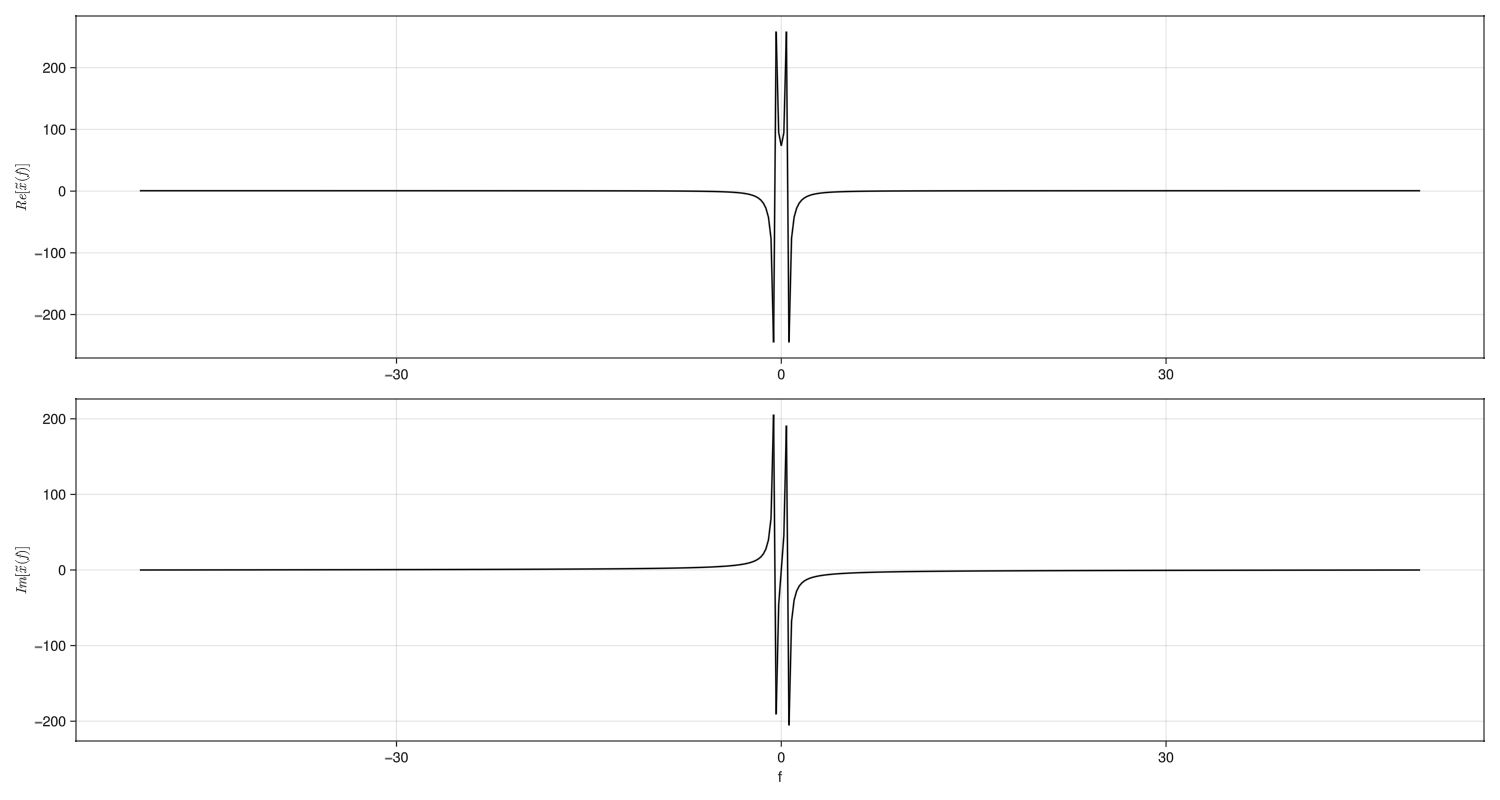

In [17]:
fig = Figure(size = (1500, 800));
ax = [
    Axis(fig[1, 1], ylabel = L"Re[\tilde{x}(f)]"),
    Axis(fig[2, 1], ylabel = L"Im[\tilde{x}(f)]", xlabel = "f")
];

f = fftshift(fft(xs[2:end]));

line = lines!(ax[1], ωs, real(f), color = :black);
line = lines!(ax[2], ωs, imag(f), color = :black);

save("assets/lecture-1/driven-harmonic-oscillator-ft.png", fig);
display("image/png", read("assets/lecture-1/driven-harmonic-oscillator-ft.png"));

<div align="center">

###  Osciladores forçados não-lineares

</div>

In [18]:
Φ = mech.anharmonicOscillator(Δx, v_0, ω_0, ζ_sup, drivingField, nonlinearOscillation);

fig = Figure(size=(1600, 600));
ax = Axis(fig[1, 1], xlabel="x", ylabel="y", limits=((-5, +5), (-2.5, +2.5)));

Points = [(Φ.x, 0)];
xs = [Φ.x];

trajectory = lines!(ax, Points, color=:gray, linestyle=:dash);
point = scatter!(ax, [(Φ.x, 0)], markersize=15, color=:black);

display(fig);
record(fig, "assets/lecture-1/anharmonic-oscillator.gif", ts; framerate=15) do t
    global Φ, Points
    mech.evolve(Φ, dt)

    push!(Points, (Φ.x, 0))
    push!(xs, Φ.x)

    if length(Points) > 15
        popfirst!(Points)
    end

    trajectory[1][] = Points
    point[1][] = [(Φ.x, 0)]

    display(fig)
end;

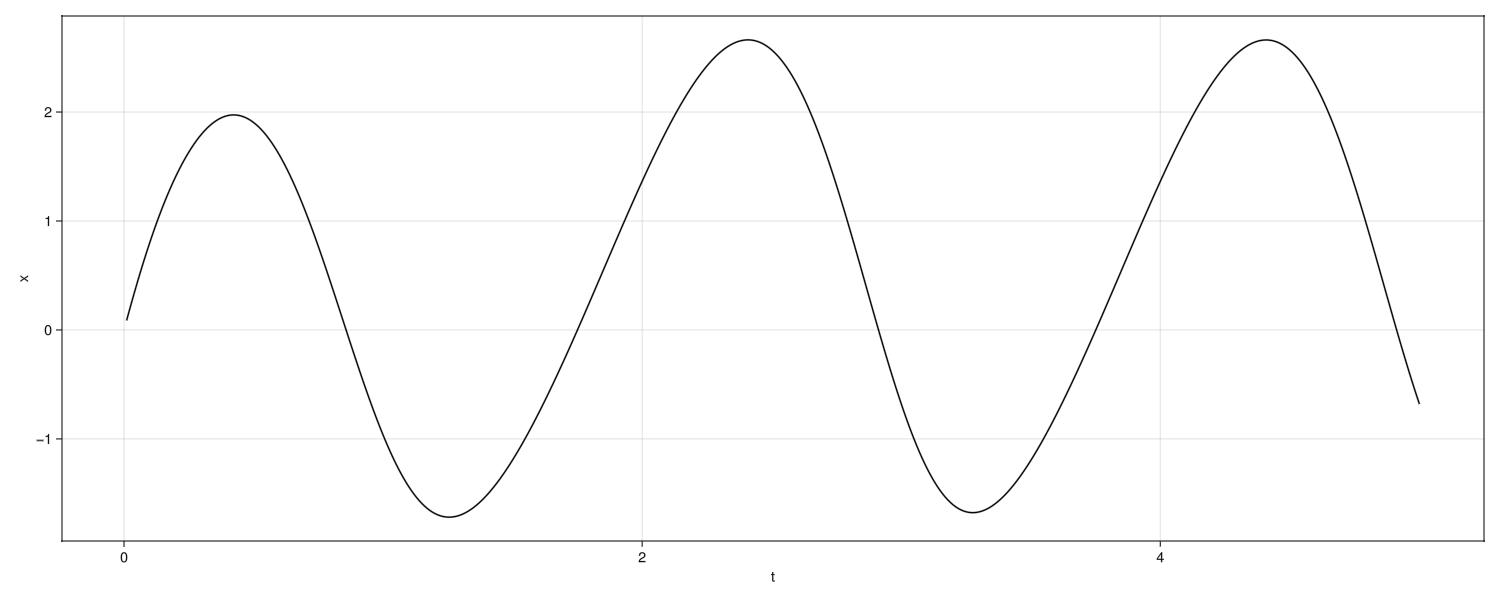

In [19]:
fig = Figure(size = (1500, 600));
ax = Axis(fig[1, 1], xlabel = "t", ylabel = "x");

line = lines!(ax, ts, xs[2:end], color=:black);

save("assets/lecture-1/anharmonic-oscillator.png", fig);
display("image/png", read("assets/lecture-1/anharmonic-oscillator.png"));

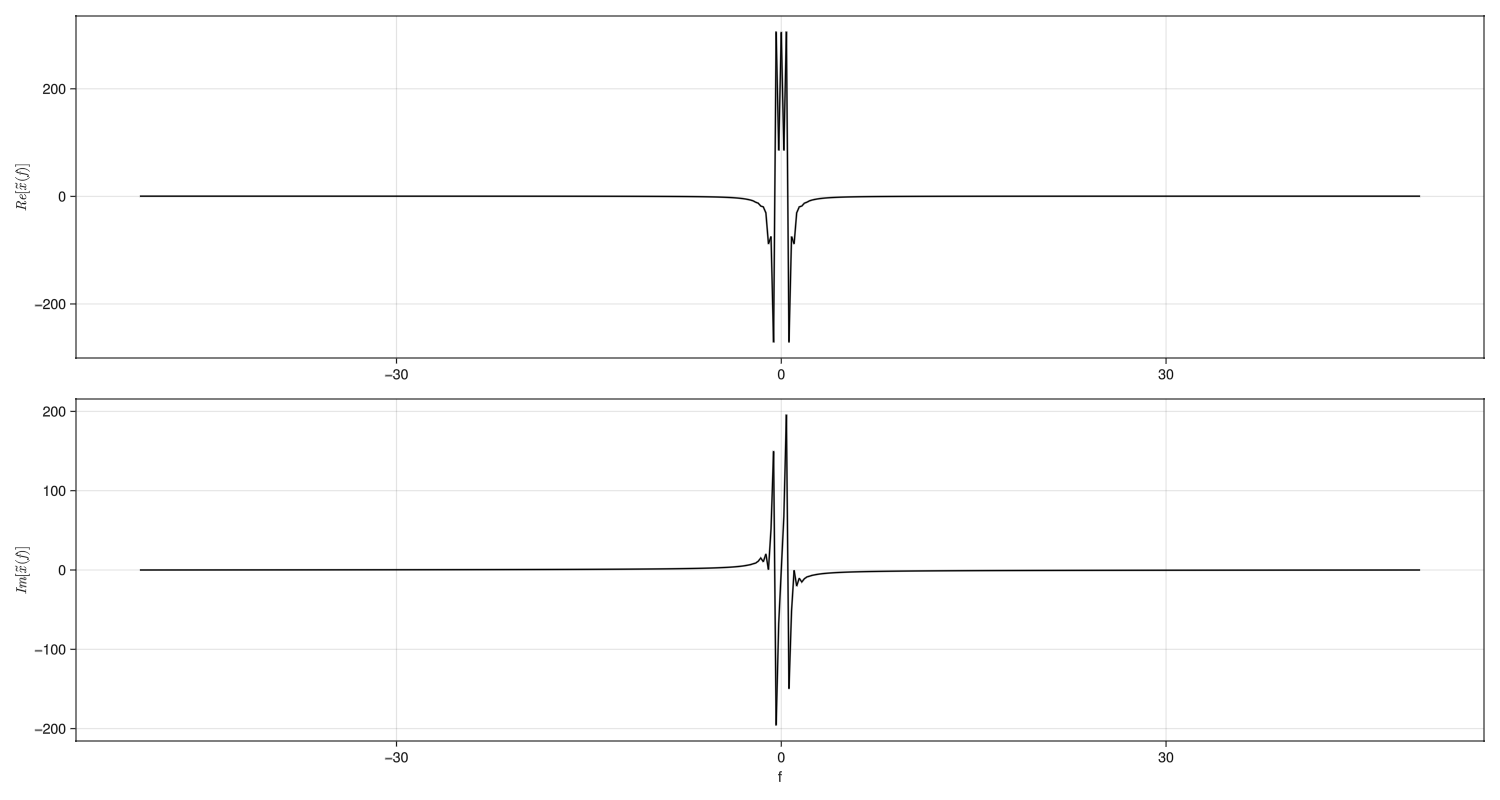

In [20]:
fig = Figure(size = (1500, 800));
ax = [
    Axis(fig[1, 1], ylabel = L"Re[\tilde{x}(f)]"),
    Axis(fig[2, 1], ylabel = L"Im[\tilde{x}(f)]", xlabel = "f")
];

f = fftshift(fft(xs[2:end]));

line = lines!(ax[1], ωs, real(f), color = :black);
line = lines!(ax[2], ωs, imag(f), color = :black);

save("assets/lecture-1/anharmonic-oscillator-ft.png", fig);
display("image/png", read("assets/lecture-1/anharmonic-oscillator-ft.png"));